# Polynomial Regression with Synthetic Data: Overview

We carry out model comparison in a simple setting of synthetic data where we also know the ground truth. 

We fit data against polynomials of different degrees with and without regularization terms and estimate how well the model generalizes to new data.

In [198]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate # pretty print tables
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [199]:
np.random.seed(42)

# Define Synthetic Data

We will generate synthetic data of the form
\begin{equation}
y = 0.5\,x^3 +0.3\,x^2-0.25\,x+1 + \mathrm{noise}\,,
\end{equation}
where
\begin{equation}
\text{noise} \sim \mathcal{N}\left(0,\sigma\right)\,.
\end{equation}
i.e. we take noise to be random normally distributed, and of given amplitude.

In [259]:
# generate normally distributed random noise with mean 0 and std dev 1

def generate_noise(x):
    return np.random.normal(0,0.5,size=x.shape)

# define a ground truth function which is a polynomial of degree 3
def y_poly(x,noise_amp=1):
    y_ground = 0.5*x**3 +0.3*x**2-0.25*x-1
    y_noise = noise_amp*generate_noise(x)
    return y_ground + y_noise

# for pretty printing the results
def enumerate_results(train_mse,test_mse,coeffstats,var,variable='degrees'):
    results = {variable: var,'train mse':train_mse,
              'test mse': test_mse}
    coef_entries = ['coef mean','coef std','coef min','coef max']
    coeffstats = np.asarray(coeffstats).T
    for i,entry in enumerate(coef_entries):
        results[entry] = coeffstats[i]
    for key in results.keys():
        if key != variable:
            # round off numbers if they are between -10 and 10, scientific notation otherwise
            results[key] = [np.format_float_scientific(c,precision=2) if np.abs(c)>=10. 
                            else np.round(c,2) for c in results[key]]
    df = pd.DataFrame(results)
    df.index += 1
    print(tabulate(df, headers = 'keys', tablefmt = 'pretty'))

# Generate Noisy Polynomials

In [201]:
# choose random points in the interval [-2,2]

n_points = 400

x_start, x_stop = -2,2

x = np.linspace(x_start,x_stop,n_points)

x = np.expand_dims(x,axis=-1)

y = y_poly(x,noise_amp=2)

## Partition data and visualize Train Data

In [202]:
# set aside 40% of the data to test the model on.
test_size = 0.4

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=test_size)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# reference points to plot the polynomial curves
x_ref = np.linspace(x_start,x_stop,n_points)

x_ref = np.expand_dims(x_ref,axis=-1)

# ground truth points without data
y_ref = y_poly(x_ref,noise_amp=0)

(240, 1) (240, 1) (160, 1) (160, 1)


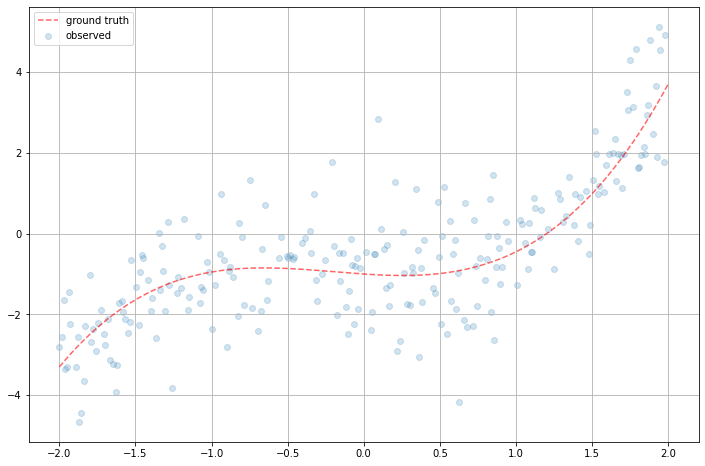

In [204]:
plt.figure(figsize=(12,8))
plt.scatter(x_train,y_train,alpha=0.2,label='observed')
plt.plot(x_ref,y_ref,color='red',linestyle='--',alpha=0.6,label='ground truth')
plt.grid('both')
plt.legend(loc='best')
plt.savefig('noisydata.pdf',format='pdf')
plt.show()

## Fitting different polynomials
Fit polynomials of different degrees to the data. We choose ansatz polynomials:
1. degree 1 : too low, linear, 
2. degree 3 : exactly matches the ground truth
3. degree 5 : slightly richer than ground truth
4. degree 50 : degree significantly higher than ground truth
5. degree 300 : degree two orders of magnitude larger

The purpose of this exercise is to see to what extent is it a good idea to choose a hypothesis class of functions of very high degree with the expectation that polynomials of lower degree will be automatically contained in this class (e.g. a cubic polynomial is a quntic polynomial with the quintic and quartic coefficients set to zero).

Secondly, note that we have 180 training points, which is about half the number of tunable parameters. We can also use this setting to gain some insight into the behaviour of _overparametrized_ models, where the number of tunable parameters exceeds the amount of training data. This is quite generically the case when working with neural networks where even moderately sized networks may have millions of tunable parameters.

In [205]:
def lin_reg_pipeline(d):
    '''returns a pipeline for fitting a univariate polynomial of degree d'''
    polybig_features = PolynomialFeatures(degree=d, include_bias=True)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
        ("poly_features", polybig_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])
    return polynomial_regression

def fit_regressor(x_train,y_train,pipeline,degree):
    '''fits a polynomial to given training data using given pipeline'''
    regressor = pipeline(degree)
    regressor.fit(x_train, y_train)
    return regressor

In [260]:
degrees = [1,3,5,50,300]

train_mse, test_mse = [], []

coefficients = []

coeffstats = []

fitted_polynomials = []

for degree in degrees:
    regressor = fit_regressor(x_train, y_train, 
                              lin_reg_pipeline,degree)
    y_tr_pred, y_te_pred, y_ref_pred = [regressor.predict(x) 
                                       for x in (x_train, x_test, x_ref)]
    tr_mse, te_mse = [mean_squared_error(*y) 
                      for y in ((y_train, y_tr_pred), (y_test,y_te_pred))]
    fitted_polynomials.append(y_ref_pred)
    train_mse.append(tr_mse)
    test_mse.append(te_mse)
    coeffs = regressor['lin_reg'].coef_[0]
    coefficients.append(coeffs)
    coeffstats.append([np.mean(coeffs),np.std(coeffs),
                       np.min(coeffs),np.max(coeffs)])

y300_unreg = fitted_polynomials[-1]

print('Enumerating Results')
enumerate_results(train_mse,test_mse,coeffstats,degrees,'degrees')

Enumerating Results
+---+---------+-----------+----------+-----------+----------+-----------+----------+
|   | degrees | train mse | test mse | coef mean | coef std | coef min  | coef max |
+---+---------+-----------+----------+-----------+----------+-----------+----------+
| 1 |    1    |   1.58    |   1.2    |   0.63    |   0.63   |    0.0    |   1.26   |
| 2 |    3    |   1.01    |   0.78   |   0.44    |   0.74   |   -0.27   |   1.67   |
| 3 |    5    |    1.0    |   0.8    |   0.29    |   1.17   |   -0.78   |   2.76   |
| 4 |   50    |   0.92    | 2.55e+02 | -1.61e+11 | 4.55e+12 | -1.36e+13 | 1.18e+13 |
| 5 |   300   |   0.74    | 2.4e+15  | -3.3e+10  | 1.24e+12 | -9.93e+12 | 4.73e+12 |
+---+---------+-----------+----------+-----------+----------+-----------+----------+


We evaluate the performance of the trained model firstly on the train set itself. Doing well on it is the zeroth order criterion that a model must satisfy. Next, we estimate the generalization error by considering the performance on the test set.

<b>Observations</b>
1. the degree 3 and 5 polynomials perform comparably on the train set. The degree 1 polynomial does the worst, and the degree 300 does the best. 
2. The degree 50 and degree 300 polynomials have an extremely large test error. 

It is then likely that the high degree polynomials have picked up spurious trends from the train set which are artefacts of noise. We can further get intuition for 
this by looking at the statistics of the learnt polynomial coefficients. These suggest that the degree 50 and 300 polynomial coefficients are very large, and the good performance on the train set is a consequence of fine-tuning.

We would then choose the degree 3 or 5 polynomials as our predictive models.

We can also confirm our statements about the polynomial coefficients by plotting it explicitly for the degree 300 case, as below.

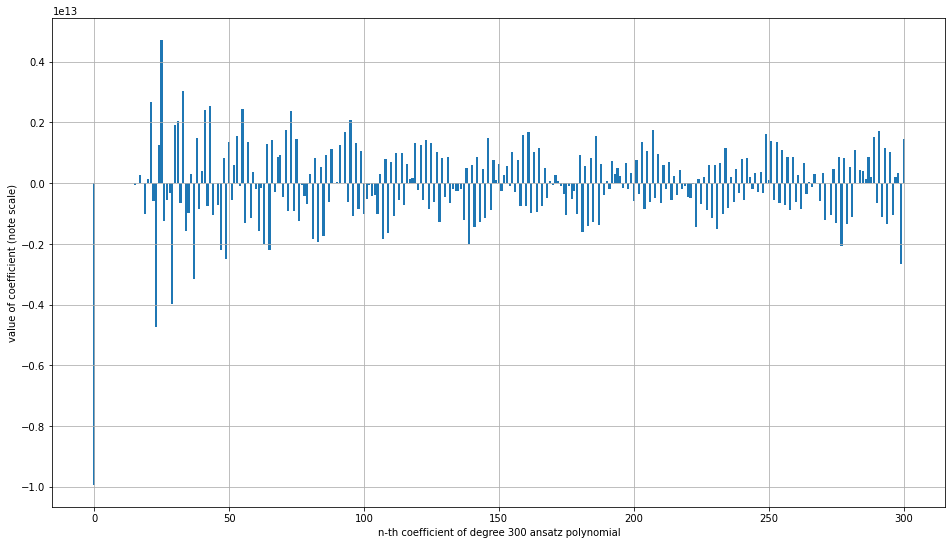

In [215]:
plt.figure(figsize=(16,9))
plt.bar(range(len(coefficients[-1])),coefficients[-1])
plt.xlabel('n-th coefficient of degree 300 ansatz polynomial')
plt.ylabel('value of coefficient (note scale)')
plt.grid('both')
plt.savefig('unregcoeffs.pdf',format='pdf')
plt.show()

## Visualize Learnt Polynomials

We have seen that the degrees 50 and 300 polynomials overfit significantly to the train set, performing terribly on the test data. The linear ansatz performs poorly on the train data itself, suggesting that it is insufficiently expressive for capturing the data's complexities.

We can verify this explicitly by visualizing these learnt polynomials in the graph below. The degree 50 and 300 polynomials are chasing noise, as we see by comparing with the ground truth. The linear polynomial on the other hand cannot capture the underlying cubic trend in the data

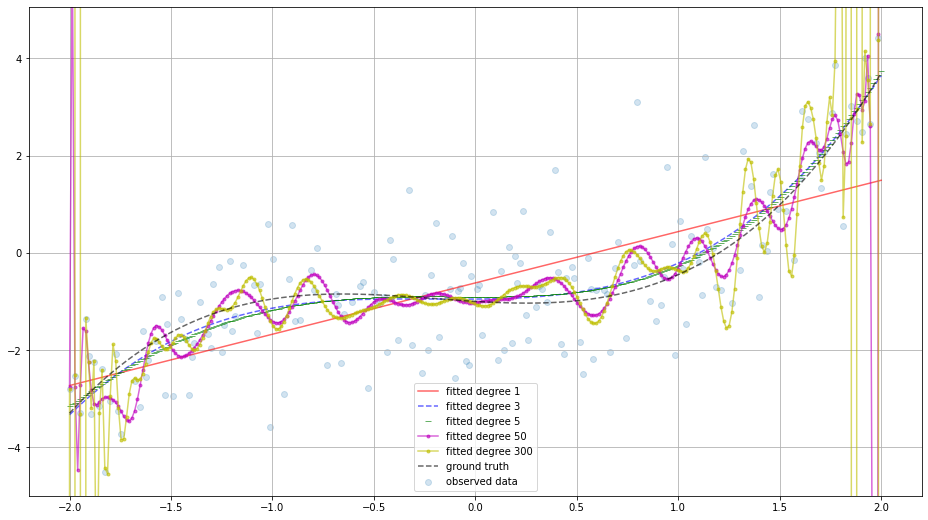

In [103]:
styles = ['r-','b--','g_', 'm.-','y.-']

plt.figure(figsize=(16,9))

for style, degree, y_ref_pred in zip(styles,degrees,fitted_polynomials):
    plt.plot(x_ref,y_ref_pred,style,
             alpha=0.6,label='fitted degree {}'.format(degree))

plt.scatter(x_train,y_train,alpha=0.2,label='observed data')
plt.plot(x_ref,y_ref,color='k',linestyle='--',alpha=0.6,label='ground truth')
plt.ylim([np.min(y)-0.5,np.max(y)+0.5])
plt.grid('both')
plt.legend(loc='best')
plt.savefig('unregulated.pdf',format='pdf')
plt.show()

# Adding a Regularization

In [499]:
def lasso_pipeline(d,alpha):
    polybig_features = PolynomialFeatures(degree=d, include_bias=True)
    std_scaler = StandardScaler()
    lasso = Lasso(alpha,max_iter=500000)
    polynomial_regression = Pipeline([
        ("poly_features", polybig_features),
        ("std_scaler", std_scaler),
        ("lasso", lasso),
    ])
    return polynomial_regression

Running the regressor with different values of regularization parameter $\alpha$. If the value of $\alpha$ is too large then the loss function will be dominated by the regularization term and we will be unable to learn anything about the data. If on the other hand, it is too small, then we will effectively be working with the unregulated model. 

In [272]:
alphas = [1e-3,1e-2,1e-1,1,10]

train_mse, test_mse = [], []

coefficients = []

coeffstats = []

fitted_polynomials = []

degree = 300

for alpha in alphas:
    pipeline = lambda x: lasso_pipeline(x,alpha=alpha)
    regressor = fit_regressor(x_train, y_train, 
                              pipeline,degree)
    y_tr_pred, y_te_pred, y_ref_pred = [regressor.predict(x) 
                                       for x in (x_train, x_test, x_ref)]
    tr_mse, te_mse = [mean_squared_error(*y) 
                      for y in ((y_train, y_tr_pred), (y_test,y_te_pred))]
    fitted_polynomials.append(y_ref_pred)
    train_mse.append(tr_mse)
    test_mse.append(te_mse)
    coeffs = regressor['lasso'].coef_
    coefficients.append(coeffs)
    coeffstats.append([np.mean(coeffs),np.std(coeffs),
                       np.min(coeffs),np.max(coeffs)])

print('Enumerating Results for the L1 regularized degree 300 polynomial')
enumerate_results(train_mse,test_mse,coeffstats,alphas,'alpha')

Enumerating Results for the L1 regularized degree 300 polynomial
+---+-------+-----------+----------+-----------+----------+----------+----------+
|   | alpha | train mse | test mse | coef mean | coef std | coef min | coef max |
+---+-------+-----------+----------+-----------+----------+----------+----------+
| 1 | 0.001 |   0.98    |   2.91   |   0.01    |   0.12   |   -0.4   |   1.89   |
| 2 | 0.01  |   0.99    |   0.77   |   0.01    |   0.07   |  -0.09   |   1.17   |
| 3 |  0.1  |   1.04    |   0.78   |   0.01    |   0.07   |   0.0    |   1.22   |
| 4 |  1.0  |   2.17    |   1.52   |    0.0    |   0.02   |   0.0    |   0.42   |
| 5 | 10.0  |   3.18    |   2.25   |    0.0    |   0.0    |   0.0    |   0.0    |
+---+-------+-----------+----------+-----------+----------+----------+----------+


We see that the lowest train and test mse are obtained when $\alpha=0.01$. These numbers are also comparable to the train and test mse numbers obtained when fitting unregulated degree 3 and 5 polynomials. Hence we see that even overparametrized polynomials are capable of interpolating the training data in a way that captures its underlying regularities once they are suitably regulated. If on the other hand, the coefficient $\alpha$ is order 1 or larger, the regressor tends to set all the coefficients to zero even to minimize the total cost function and is therefore not able to learn anything about the data.

To concretize these remarks, we can explicitly plot the learnt polynomials along with the ground truth, training data and the unregulated polynomial. We indeed find that the regulated polynomials capture the underlying trend accurately.

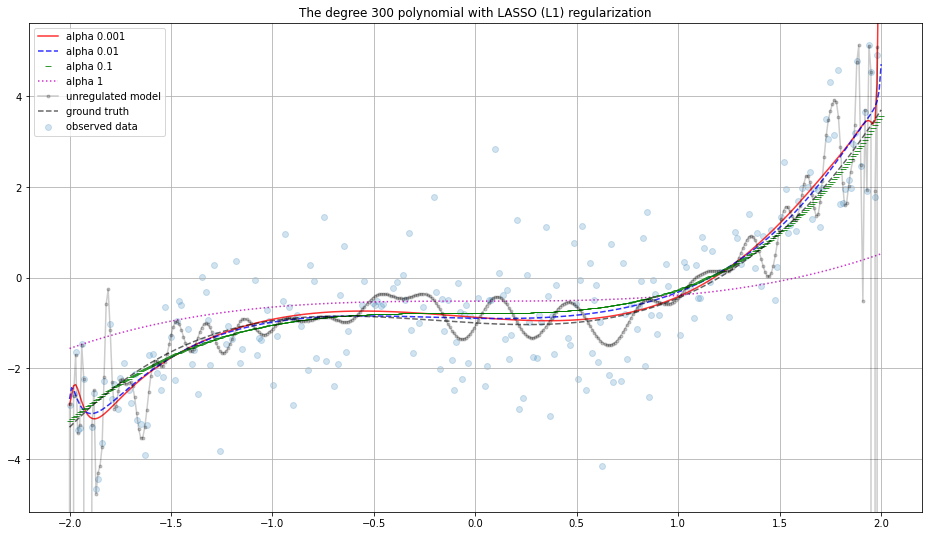

In [273]:
styles = ['r-','b--','g_', 'm:']

plt.figure(figsize=(16,9))

for style, alpha, y_ref_pred in zip(styles,alphas,fitted_polynomials):
    plt.plot(x_ref,y_ref_pred,style,
           alpha=0.8,label='alpha {}'.format(alpha))

plt.plot(x_ref,y300_unreg,'k.-',alpha=0.2,label='unregulated model')

plt.scatter(x_train,y_train,alpha=0.2,label='observed data')
plt.plot(x_ref,y_ref,color='k',linestyle='--',alpha=0.6,label='ground truth')
plt.ylim([np.min(y)-0.5,np.max(y)+0.5])
plt.grid('both')
plt.legend(loc='best')
plt.savefig('regulated.pdf',format='pdf')
plt.title('The degree 300 polynomial with LASSO (L1) regularization')
plt.show()

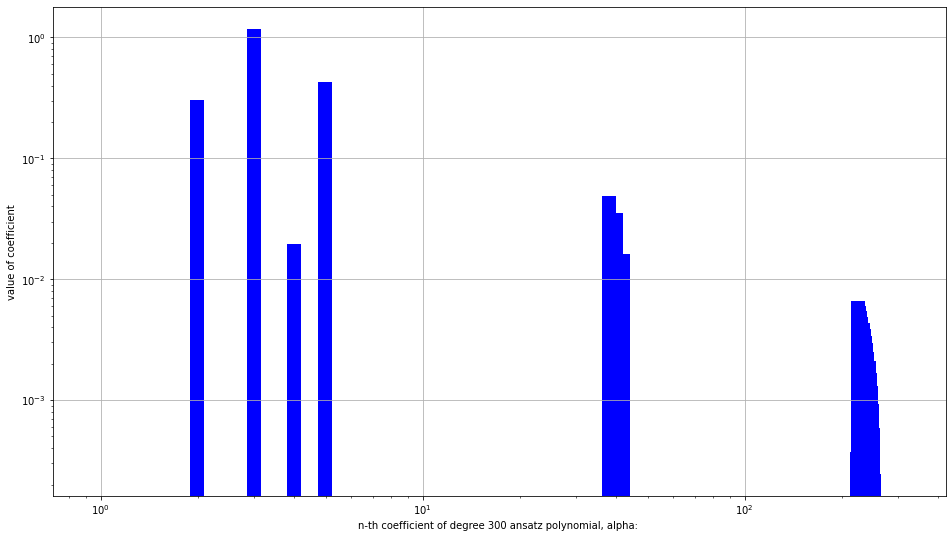

In [292]:
fig, ax = plt.subplots(figsize=(16,9))
y = coefficients[1]
x = range(len(y))
ax.bar(x,y,width=0.1*np.asarray(x), color='b', log=True)
ax.set_xlabel('n-th coefficient of degree 300 ansatz polynomial, alpha: '.format(alphas[1]))
ax.set_ylabel('value of coefficient')
ax.grid('both')
ax.set_xscale('log')
plt.savefig('unregcoeffs.pdf',format='pdf')
plt.show()